<a href="https://colab.research.google.com/github/Vardhan-8/image-Sharpening-/blob/main/image_sharping_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python numpy tensorflow scikit-learn matplotlib tqdm

In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


tf.random.set_seed(42)
np.random.seed(42)

In [12]:
def prepare_dataset(blurred_folder, sharp_folder, target_size=(256, 256), max_samples=1000):

    blurred_images = []
    sharp_images = []


    blurred_files = sorted(os.listdir(blurred_folder))[:max_samples]
    sharp_files = sorted(os.listdir(sharp_folder))[:max_samples]

    assert len(blurred_files) == len(sharp_files), "Folder contents don't match"

    for blur_name, sharp_name in tqdm(zip(blurred_files, sharp_files),
                                    desc="Loading image pairs",
                                    total=min(len(blurred_files), max_samples)):
        # Load blurred image
        blur_path = os.path.join(blurred_folder, blur_name)
        blur_img = cv2.imread(blur_path)
        if blur_img is None:
            continue

        # Load sharp image
        sharp_path = os.path.join(sharp_folder, sharp_name)
        sharp_img = cv2.imread(sharp_path)
        if sharp_img is None:
            continue


        blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB)
        sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB)

        blur_img = cv2.resize(blur_img, target_size)
        sharp_img = cv2.resize(sharp_img, target_size)

        blurred_images.append(blur_img)
        sharp_images.append(sharp_img)

    # Convert to numpy arrays
    blurred_images = np.array(blurred_images, dtype=np.float32) / 255.0
    sharp_images = np.array(sharp_images, dtype=np.float32) / 255.0

    return blurred_images, sharp_images

In [4]:

blurred_folder = "/content/drive/MyDrive/programs/data_blurred"
sharp_folder = "/content/drive/MyDrive/programs/data_sharp"

if not os.path.exists(blurred_folder):
    print(f"Error: Blurred folder not found at {blurred_folder}")
elif not os.path.exists(sharp_folder):
    print(f"Error: Sharp folder not found at {sharp_folder}")
else:
    # Check if the number of files match
    blurred_files = sorted(os.listdir(blurred_folder))
    sharp_files = sorted(os.listdir(sharp_folder))
    if len(blurred_files) != len(sharp_files):
        print(f"Error: Number of files in blurred folder ({len(blurred_files)}) "
              f"does not match the number of files in sharp folder ({len(sharp_files)}).")
    else:
        blurred_imgs, sharp_imgs = prepare_dataset(
            blurred_folder=blurred_folder,
            sharp_folder=sharp_folder,
            target_size=(256, 256),
            max_samples=1000
        )

        # Split into train/validation
        X_train, X_val, y_train, y_val = train_test_split(blurred_imgs, sharp_imgs, test_size=0.2)

Loading image pairs: 100%|██████████| 347/347 [09:21<00:00,  1.62s/it]


In [8]:
def build_teacher_model(input_shape=(256, 256, 3)):
    """Build the teacher model with more capacity"""
    inputs = layers.Input(shape=input_shape)

    # Initial feature extraction
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Middle layers
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    # Upsampling
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Output
    outputs = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

teacher_model = build_teacher_model()
teacher_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae'])
teacher_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,700,483 (6.49 MB)

 Trainable params: 1,700,483 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def build_student_model(input_shape=(256, 256, 3)):
    """Build the lightweight student model"""
    inputs = layers.Input(shape=input_shape)


    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)


    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Upsampling
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Output
    outputs = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

student_model = build_student_model()
student_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae'])
student_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 256, 256, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 256, 256, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 128, 128, 128)  │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 128, 128, 128)  │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 256, 256, 64)   │         9,408 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 256, 256, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,715 (233.26 KB)

 Trainable params: 59,715 (233.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def calculate_metrics(y_true, y_pred):

    ssim_values = []
    psnr_values = []

    for i in range(len(y_true)):

        true_img = (y_true[i] * 255).astype(np.uint8)
        pred_img = (y_pred[i] * 255).astype(np.uint8)


        ssim_val = ssim(true_img, pred_img,
                       multichannel=True,
                       channel_axis=-1,
                       data_range=255)
        psnr_val = psnr(true_img, pred_img, data_range=255)

        ssim_values.append(ssim_val)
        psnr_values.append(psnr_val)

    return np.mean(ssim_values), np.mean(psnr_values)

class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        sample_idx = np.random.choice(len(X_val), 5, replace=False)
        X_sample = X_val[sample_idx]
        y_sample = y_val[sample_idx]


        y_pred = self.model.predict(X_sample, verbose=0)


        ssim_val, psnr_val = calculate_metrics(y_sample, y_pred)


        logs['val_ssim'] = ssim_val
        logs['val_psnr'] = psnr_val

        print(f" - val_SSIM: {ssim_val:.4f} - val_PSNR: {psnr_val:.2f} dB")

In [10]:
class Distiller(models.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha

    def train_step(self, data):
        x, y = data


        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:

            student_predictions = self.student(x, training=True)


            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(teacher_predictions, student_predictions)
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss


        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)


        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


        self.compiled_metrics.update_state(y, student_predictions)


        results = {m.name: m.result() for m in self.metrics}
        results.update({
            "student_loss": student_loss,
            "distillation_loss": distillation_loss,
        })
        return results

    def test_step(self, data):
        x, y = data


        y_prediction = self.student(x, training=False)

        student_loss = self.student_loss_fn(y, y_prediction)


        self.compiled_metrics.update_state(y, y_prediction)


        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['mae'],
    student_loss_fn=losses.MeanSquaredError(),
    distillation_loss_fn=losses.MeanSquaredError(),
    alpha=0.5
)

In [23]:
def train_models(X_train, y_train, X_val, y_val, teacher_epochs=50, student_epochs=80, batch_size=8):
    """Train both teacher and student models"""
    # Train teacher model
    print("Training teacher model...")
    teacher_history = teacher_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=teacher_epochs,
        batch_size=batch_size
    )


    print("\nTraining student with distillation...")
    distillation_history = distiller.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=student_epochs,
        batch_size=batch_size
    )

    return teacher_history, distillation_history


teacher_hist, student_hist = train_models(X_train, y_train, X_val, y_val,
                                       teacher_epochs=50,
                                       student_epochs=80)

Training teacher model...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 0.0323 - mae: 0.1343 - val_loss: 0.0376 - val_mae: 0.1457
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - loss: 0.0317 - mae: 0.1327 - val_loss: 0.0370 - val_mae: 0.1436
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - loss: 0.0314 - mae: 0.1314 - val_loss: 0.0371 - val_mae: 0.1451
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - loss: 0.0314 - mae: 0.1316 - val_loss: 0.0368 - val_mae: 0.1434
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - loss: 0.0309 - mae: 0.1301 - val_loss: 0.0375 - val_mae: 0.1460
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - loss: 0.0310 - mae: 0.1306 - val_loss: 0.0371 - val_mae: 0.1434
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.0309 - mae: 0.1300 - val_loss: 0.0374 - val_mae: 0.1451
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - loss: 0.0306 - mae: 0.1294 - val_loss: 0.0373 - val_mae: 0.1445
Epoch 9/50
35/35 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - mae: 0.2266 - distillation_loss: 0.0406 - loss: 0.4905 - student_loss: 0.0701

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - mae: 0.2268 - distillation_loss: 0.0407 - loss: 0.4902 - student_loss: 0.0702 - val_loss: 0.4425 - val_student_loss: 0.0623
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - mae: 0.2247 - distillation_loss: 0.0406 - loss: 0.4424 - student_loss: 0.0696 - val_loss: 0.4584 - val_student_loss: 0.0632
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - mae: 0.2244 - distillation_loss: 0.0403 - loss: 0.4535 - student_loss: 0.0693 - val_loss: 0.4535 - val_student_loss: 0.0627
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - mae: 0.2126 - distillation_loss: 0.0274 - loss: 0.4553 - student_loss: 0.0547 - val_loss: 0.4596 - val_student_loss: 0.0493
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - mae: 0.1601 - distillation_loss: 0.0145 - loss: 0.4527 - student_loss: 0.0405 - val_loss: 0.4283 - val_student_loss: 0.0448
Epoch 6/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - mae: 0.1520 - distillation_loss: 0.0127 - loss: 0.4553 - studen

In [48]:
def process_full_resolution(image_path, model, tile_size=256, overlap=32):


    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    img = img.astype(np.float32) / 255.0


    output = np.zeros_like(img)
    count = np.zeros((h, w, 1), dtype=np.float32)

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Get tile coordinates
            y1, y2 = y, min(y + tile_size, h)
            x1, x2 = x, min(x + tile_size, w)


            tile = img[y1:y2, x1:x2]
            if tile.shape[0] < tile_size or tile.shape[1] < tile_size:

                pad_h = tile_size - tile.shape[0]
                pad_w = tile_size - tile.shape[1]
                tile = np.pad(tile, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')


            tile_input = np.expand_dims(tile, axis=0)
            sharp_tile = model.predict(tile_input, verbose=0)[0]


            sharp_tile = sharp_tile[:y2-y1, :x2-x1]


            weight = np.ones_like(sharp_tile)
            if y1 > 0:

                fade = min(overlap, y2-y1)
                weight[:fade] *= np.linspace(0, 1, fade)[:, np.newaxis, np.newaxis]
            if y2 < h:

                fade = min(overlap, y2-y1)
                weight[-fade:] *= np.linspace(1, 0, fade)[:, np.newaxis, np.newaxis]
            if x1 > 0:

                fade = min(overlap, x2-x1)
                weight[:, :fade] *= np.linspace(0, 1, fade)[np.newaxis, :, np.newaxis]
            if x2 < w:

                fade = min(overlap, x2-x1)
                weight[:, -fade:] *= np.linspace(1, 0, fade)[np.newaxis, :, np.newaxis]

            output[y1:y2, x1:x2] += sharp_tile * weight
            count[y1:y2, x1:x2] += weight


    output = np.clip(output / count, 0, 1)
    return (output * 255).astype(np.uint8)



Teacher Results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


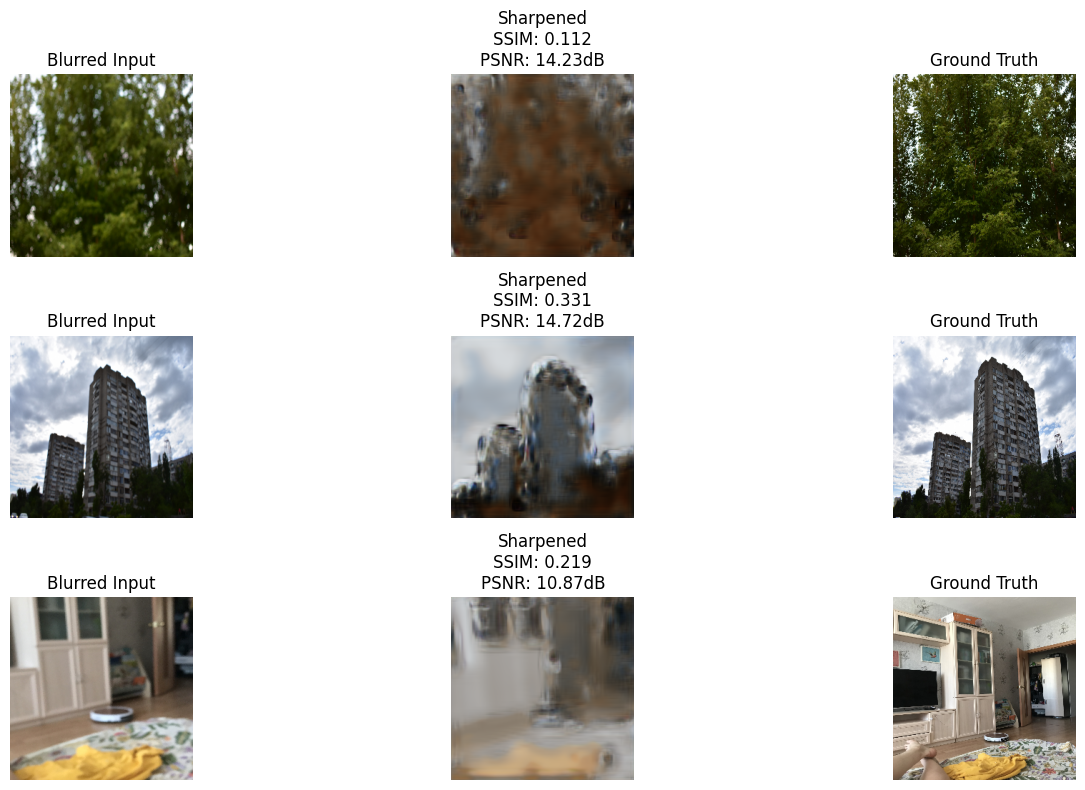


Student Results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


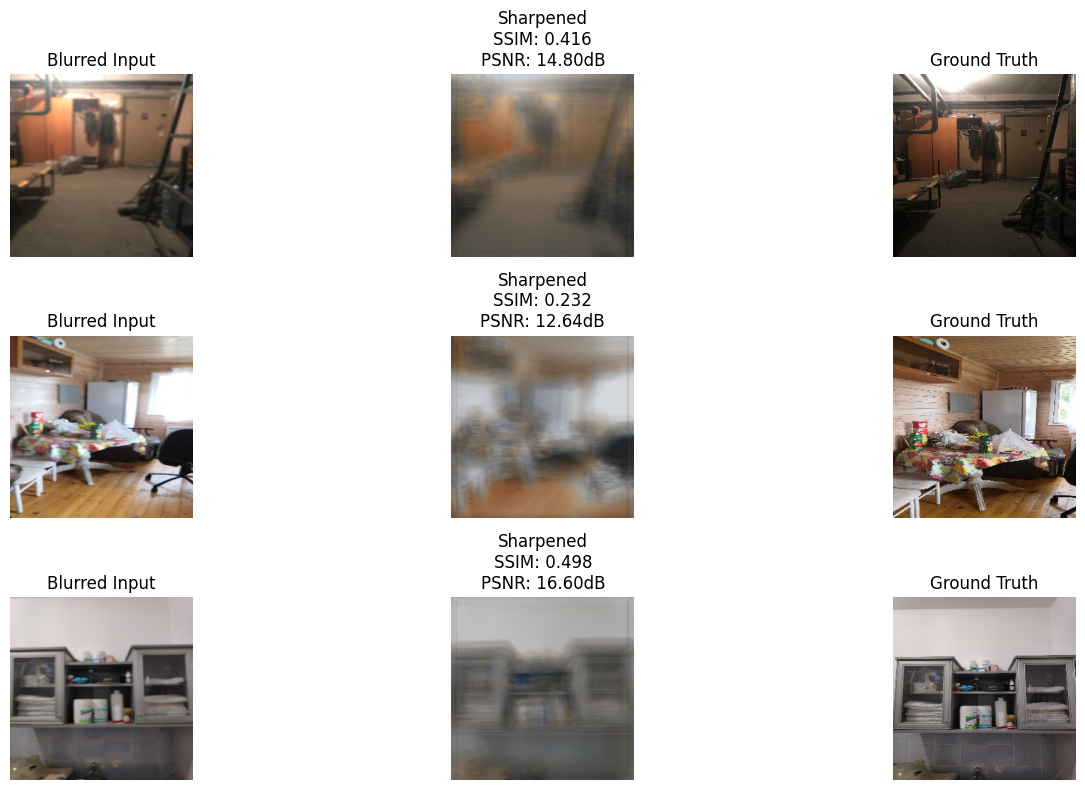

In [34]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate(model, X, y, n=3):
    plt.figure(figsize=(15, 8))
    idx = np.random.choice(len(X), n)

    for i in range(n):
        pred = model.predict(np.expand_dims(X[idx[i]], axis=0))[0]

        plt.subplot(n, 3, i*3+1)
        plt.imshow(X[idx[i]])
        plt.title("Blurred Input")
        plt.axis('off')

        plt.subplot(n, 3, i*3+2)
        plt.imshow(pred)
        plt.title(f"Sharpened\nSSIM: {ssim(y[idx[i]], pred, channel_axis=-1, data_range=1):.3f}\nPSNR: {psnr(y[idx[i]], pred, data_range=1):.2f}dB")
        plt.axis('off')

        plt.subplot(n, 3, i*3+3)
        plt.imshow(y[idx[i]])
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Teacher Results:")
evaluate(teacher_model, X_val, y_val)

print("\nStudent Results:")
evaluate(student_model, X_val, y_val)

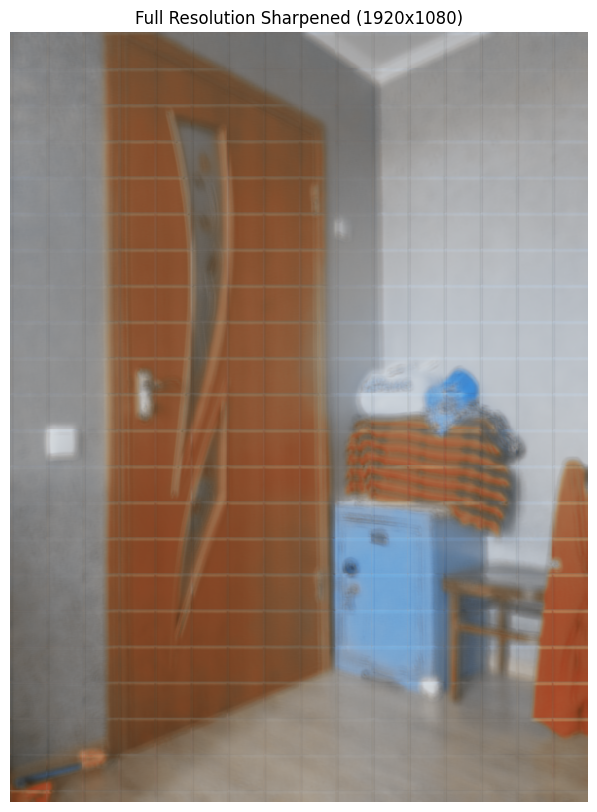

In [47]:
def process_high_res(image_path, model, tile_size=128, overlap=32):
    """Process high-res images with error handling"""
    # Verify image loading
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to read image at {image_path}. Check: "
                       f"1) File exists 2) Valid image format 3) File permissions")

    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        img = img.astype(np.float32)/255.0

        output = np.zeros_like(img)

        for y in range(0, h, tile_size-overlap):
            for x in range(0, w, tile_size-overlap):
                tile = img[y:min(y+tile_size,h), x:min(x+tile_size,w)]
                if tile.shape[0] < tile_size or tile.shape[1] < tile_size:
                    tile = np.pad(tile, [(0, tile_size-tile.shape[0]),
                                        (0, tile_size-tile.shape[1]),
                                        (0,0)], mode='reflect')

                sharp_tile = model.predict(np.expand_dims(tile, axis=0), verbose=0)[0]
                sharp_tile = sharp_tile[:min(y+tile_size,h)-y, :min(x+tile_size,w)-x]

                output[y:min(y+tile_size,h), x:min(x+tile_size,w)] = sharp_tile

        return (output*255).astype(np.uint8)

    except Exception as e:
        raise RuntimeError(f"Error processing image: {str(e)}")


try:
    high_res_sharp = process_high_res("/content/drive/MyDrive/programs/data_sharp/12_SAMSUNG-GALAXY-J5_S.jpg", student_model)
    plt.figure(figsize=(20,10))
    plt.imshow(high_res_sharp)
    plt.title("Full Resolution Sharpened (1920x1080)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error: {e}")